In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *
import myplot

import h5py
import numpy as np
import matplotlib.pyplot as plt

2022-03-31 09:11:34.316354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 09:11:34.316377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
## import data
folder = '/home/ym917/OneDrive/PhD/Code_md-ae/Hierarchical_2_1__2022_03_29__10_14_44/'
filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
u_avg = np.array(hf.get('u_avg'))
hf.close()

In [3]:
## load model
filename = folder + 'subnet1'
subnet1 = tf.keras.models.load_model(filename)
filename = folder + 'subnet2'
subnet2 = tf.keras.models.load_model(filename)

2022-03-31 09:11:37.298992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 09:11:37.299016: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 09:11:37.299032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist
2022-03-31 09:11:37.299424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


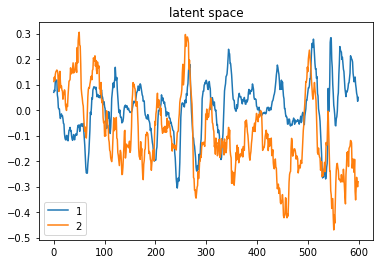

In [4]:
## latent space
z1 = subnet1.encoder.predict(u_test)
z2 = subnet2.encoder.predict(u_test)
plt.figure()
plt.plot(z1,label='1')
plt.plot(z2,label='2')
plt.legend()
plt.title('latent space')
plt.show()

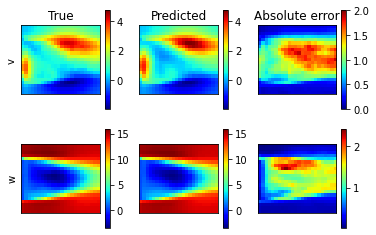

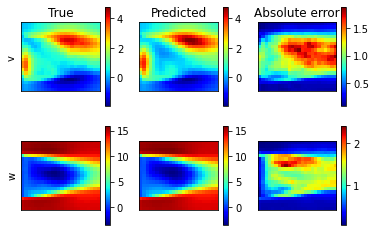

In [5]:
# autoencoder results
y_test = subnet1.predict([u_test])
# y_test = subnet2.predict([u_test,z1])

myplot.plot_ae_results(u_test,y_test,u_avg,'mae')

In [7]:
## modes
mode1 = subnet1.predict([u_test])
mode2 = subnet2.predict([u_test,z1]) - mode1
print(mode1.shape)

(600, 21, 24, 2)


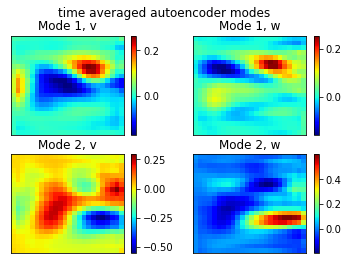

In [13]:
## time averaged modes
fig,ax = plt.subplots(2,2)

plt.suptitle('time averaged autoencoder modes')
mode1_v = ax[0,0].imshow(np.mean(mode1,axis=0)[:,:,0],'jet')
ax[0,0].set_title('Mode 1, v')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(mode1_v,ax=ax[0,0])

mode1_w = ax[0,1].imshow(np.mean(mode1,axis=0)[:,:,1],'jet')
ax[0,1].set_title('Mode 1, w')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(mode1_w,ax=ax[0,1])

mode2_v = ax[1,0].imshow(np.mean(mode2,axis=0)[:,:,0],'jet')
ax[1,0].set_title('Mode 2, v')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(mode2_v,ax=ax[1,0])

mode2_w = ax[1,1].imshow(np.mean(mode2,axis=0)[:,:,1],'jet')
ax[1,1].set_title('Mode 2, w')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(mode2_w,ax=ax[1,1])

plt.show()

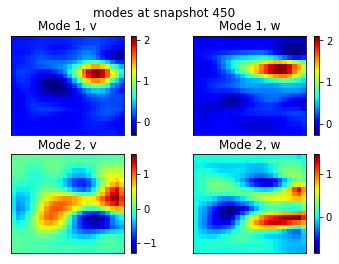

In [17]:
## plt modes
fig,ax = plt.subplots(2,2)
time = 450

plt.suptitle('modes at snapshot '+str(time))
mode1_v = ax[0,0].imshow(mode1[time,:,:,0],'jet')
ax[0,0].set_title('Mode 1, v')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(mode1_v,ax=ax[0,0])

mode1_w = ax[0,1].imshow(mode1[time,:,:,1],'jet')
ax[0,1].set_title('Mode 1, w')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(mode1_w,ax=ax[0,1])

mode2_v = ax[1,0].imshow(mode2[time,:,:,0],'jet')
ax[1,0].set_title('Mode 2, v')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(mode2_v,ax=ax[1,0])

mode2_w = ax[1,1].imshow(mode2[time,:,:,1],'jet')
ax[1,1].set_title('Mode 2, w')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(mode2_w,ax=ax[1,1])

plt.show()

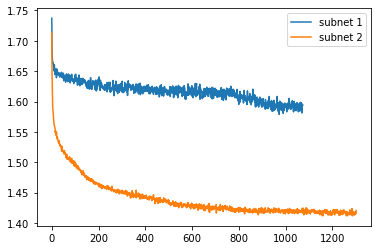

In [10]:
idx = np.where(hist_train == -1)[0]
plt.figure()
plt.plot(hist_train[:idx[0]],label='subnet 1')
plt.plot(hist_train[idx[0]+1:],label='subnet 2') 
plt.legend()
plt.show()